In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)

plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings
do_compile = True
threads = 50

# from consav import cpptools
# cpptools.setup_nlopt(folder='cppfuncs/', do_print = True) #install nlopt

# Solve and simulate from alternative models

In [2]:
# settings for models to solve
T = 10
specs = {
    
    'model_NC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'threads':threads,'bargaining':2}},
    'model_LC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'threads':threads,'bargaining':1}},
    'model_FC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'threads':threads,'bargaining':0}},

}



In [3]:
# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    print(f'{name} loading...',end='')
    
    # setup model
    models[name] = LimitedCommitmentModelClass(name=name,par=spec['par'])
    models[name].spec = spec

    compile_now = True if do_compile & (m==0) else False
    models[name].link_to_cpp(force_compile=compile_now)
    
    print(' solving...')
    %time models[name].solve() 
    
    %time models[name].simulate() 
    # 25min 42s

model_NC loading... solving...
CPU times: total: 16h 35min 57s
Wall time: 30min 39s
CPU times: total: 5.44 s
Wall time: 154 ms
model_LC loading... solving...
CPU times: total: 13h 52min 26s
Wall time: 26min 7s
CPU times: total: 703 ms
Wall time: 8.67 ms
model_FC loading... solving...
CPU times: total: 19h 18min 34s
Wall time: 48min 42s
CPU times: total: 734 ms
Wall time: 6.99 ms


In [4]:
model_name = 'model_FC'
model = models[model_name]
sol = model.sol
par = model.par
sim = model.sim

t = 0
iZw = 0
iZm = 0
iL = 5
iA = 10 #10 # if little assets: bargaining power does not matter for surplus
iKw = 2
iKm = 2
for iP in (1,4,5,6,7,10):
    print(f'{iP} / {par.grid_power[iP]:.2f}')
    Sw = sol.Vw_remain_couple[t,iZw,iZm,iP,iL,iA,iKw,iKm]-sol.Vw_trans_single[t,iZw,iA,iKw]
    Sm = sol.Vm_remain_couple[t,iZw,iZm,par.num_power-iP-1,iL,iA,iKw,iKm]-sol.Vm_trans_single[t,iZm,iA,iKm]
    print(f'Sw:{Sw:2.7f} Sm:{Sm:2.7f}')
    print(f'SwSm = {Sw*Sm:2.8f}')
    labor_w = sol.labor_w_remain_couple[t,iZw,iZm,iP,iL,iA,iKw,iKm]
    labor_m = sol.labor_m_remain_couple[t,iZw,iZm,iP,iL,iA,iKw,iKm]
    print(f'labor_w:{labor_w:2.7f} labor_m:{labor_m:2.7f}')
    

# tester
love = par.grid_love[iL]
Aw = par.grid_Aw[iA]
Am = par.grid_Am[iA]
Kw = par.grid_K[iKw]
Km = par.grid_K[iKw]
power = model.cpp.calc_bargaining_weight(t,love,Aw,Am,Kw,Km,iZw,iZm,sol,par)
print(power)


1 / 0.06
Sw:10.9000962 Sm:10.9003815
SwSm = 118.81520736
labor_w:1.0000000 labor_m:0.5696130
4 / 0.33
Sw:12.0489775 Sm:12.0440071
SwSm = 145.11797084
labor_w:1.0000000 labor_m:0.7581175
5 / 0.50
Sw:12.9446745 Sm:12.9435014
SwSm = 167.54941240
labor_w:0.9847041 labor_m:0.9845031
6 / 0.67
Sw:13.5560407 Sm:13.5537392
SwSm = 183.73504059
labor_w:0.7581175 labor_m:1.0000000
7 / 0.78
Sw:13.7620168 Sm:13.7625125
SwSm = 189.39992876
labor_w:0.6665959 labor_m:1.0000000
10 / 1.00
Sw:13.8659906 Sm:13.8659553
SwSm = 192.26520497
labor_w:0.5394138 labor_m:1.0000000
0.5


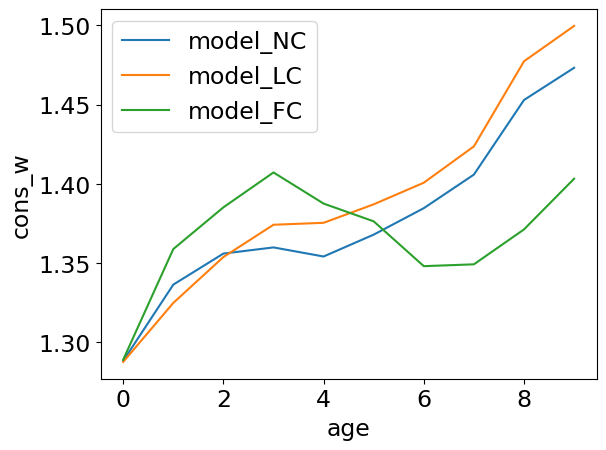

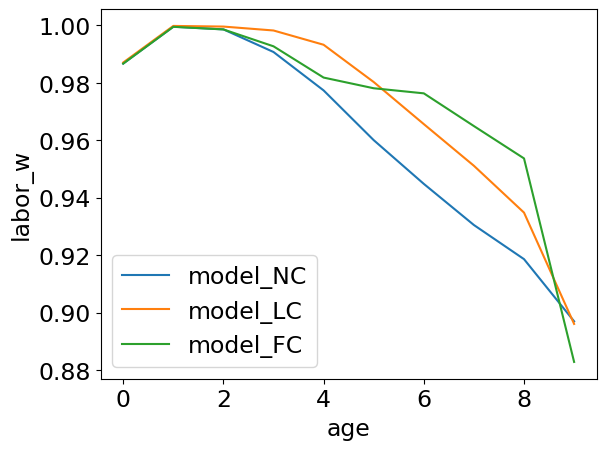

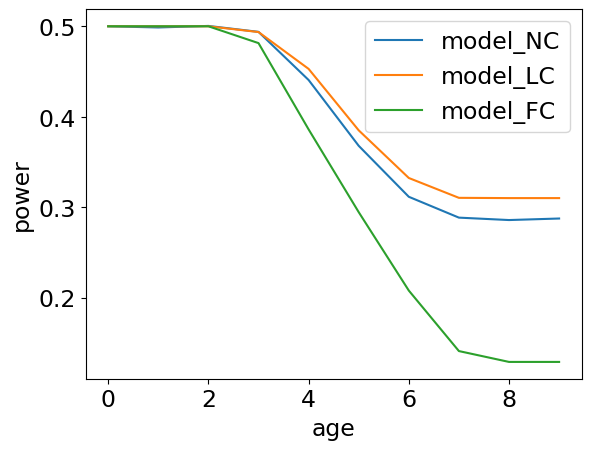

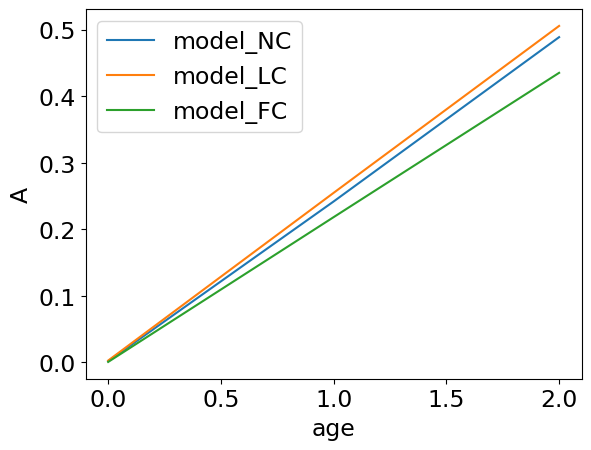

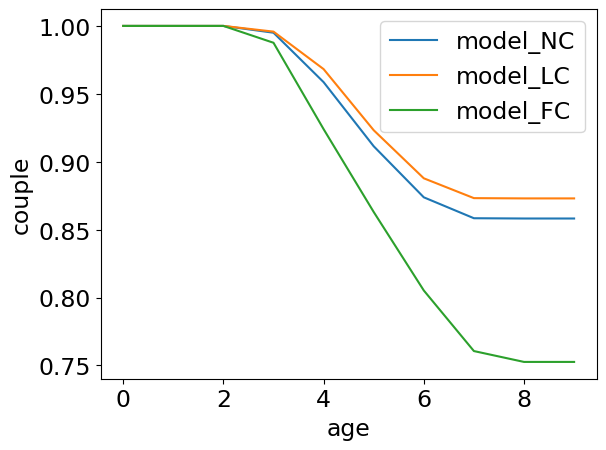

In [5]:
var_list = ('cons_w','labor_w','power','A','couple')
idxA = 0
for var in var_list:
    fig,ax = plt.subplots()
    for model_name in ('model_NC','model_LC','model_FC'):
        model = models[model_name]
        sol = model.sol
        par = model.par
        sim = model.sim
        
        par.bargaining_init_nash = True
        sim.init_A = par.grid_A[idxA] + np.zeros(par.simN)
        sim.init_Aw = par.grid_Aw[idxA] + np.zeros(par.simN)
        sim.init_Am = par.grid_Am[idxA] +  np.zeros(par.simN)
        model.simulate()
        
        # plot simulations
        ax.plot(np.mean(getattr(sim,var),axis=0),label=model_name)
    ax.set(xlabel='age',ylabel=var)
    ax.legend()

In [6]:
stop

NameError: name 'stop' is not defined

In [ ]:
iZw = 0
iZm = 0
iP = 5
iL = 0
iA = 250
iKw = 2
iKm = 2
diff = sol.Vw_remain_couple[par.T-1,iZw,iZm,iP,iL,iA,iKw,iKm] - sol.Vm_remain_couple[par.T-1,iZw,iZm,par.num_power-1-iP,iL,iA,iKw,iKm]
diff_abs = np.abs(diff.ravel()).max()
print(diff_abs)
plt.hist(diff.ravel(),bins=100);

In [ ]:
plt.plot(par.grid_power,sol.Vw_remain_couple[par.T-1,iZw,iZm,:,iL,iA,iKw,iKm],marker='o')
plt.plot(par.grid_power,sol.Vm_remain_couple[par.T-1,iZw,iZm,:,iL,iA,iKw,iKm],marker='+')

In [ ]:
# stop

# Policy functions

## Singles

In [ ]:
# model_list = ('model_NC','model_LC','model_FC',)
model_list = ('model_NC',)
# model_list = ('model 3, full',)
sol_type ='single'
par = models[model_list[0]].par
iZ = 0
cmaps = ('viridis','gray')
for t in (0,):
    for var in ('V','cons','labor'):
        for sex in (1,2):
            sex_str = 'w' if sex==1 else 'm'
            if var not in ('V',):
                sex_str = f'_{sex_str}'
            var_now = var
            var_now += f'{sex_str}_{sol_type}'
            
            fig = plt.figure()
            ax = plt.axes(projection='3d')

            grid_A = par.grid_Aw if sex==1 else par.grid_Am
            X, Y = np.meshgrid(grid_A, par.grid_K,indexing='ij')
            
            for i,name in enumerate(model_list):
                model = models[name]
                
                Z = getattr(model.sol,var_now)[t,iZ]
                
                #Z = getattr(model.sol,var)[t,:,iL,:,iKw,iKm]
                
                alpha = 0.5 if name=='model 1' else 0.7
                ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
                
                ax.set(xlabel='$A_{j,t-1}$',ylabel='$K_{j,t}$');
                
            fig_name = f'sol {var_now} t{t}{sex_str}'
            plt.tight_layout()
            if SAVE: 
                plt.savefig(path+fig_name+'.pdf')
            else:
                ax.set(title=fig_name)

## Couples
Plot policy functions as a function of woman's power and household wealth

In [ ]:
model_list = ('model_NC','model_LC','model_FC',)
model_list = ('model_NC',)
# model_list = ('model 3, full',)
sol_type ='remain_couple'
par = models[model_list[0]].par


t = 0
iK = 5
iKw = iK
iKm = iK
iZw = 0
iZm = 0

print(np.mean(model.sol.cons_w_remain_couple[t].ravel())) # 10.351192584353102 t=T-1, 8.307694301145856 at t=T-2

X, Y = np.meshgrid(par.grid_power, par.grid_A,indexing='ij')

cmaps = ('viridis','gray')
for iL in (par.num_love//2,): 
    for var in ('Vw','Vm','cons_w','cons_m','labor_w','labor_m','power'):
        if var != 'power': 
            var += f'_{sol_type}'
        
        fig = plt.figure()
        ax = plt.axes(projection='3d')
        
        for i,name in enumerate(model_list):
            model = models[name]
            
            Z = getattr(model.sol,var)[t,iZw,iZm,:,iL,:,iKw,iKm]
            
            
            alpha = 0.5 if name=='model 1' else 0.7
            ax.plot_surface(X, Y, Z,rstride=1,cstride=1,cmap=cmaps[i], edgecolor='none',alpha=alpha);
            
            if var == 'power': 
                ax.set(zlim=[0.0,1.0])
            ax.set(xlabel='$\mu_{t-1}$',ylabel='$A_{t-1}$');
            
        fig_name = f'sol {var} t{t}_love{np.round(par.grid_love[iL]):1.2f}'
        plt.tight_layout()
        if SAVE: 
            plt.savefig(path+fig_name+'.pdf')
        else:
            ax.set(title=fig_name)

In [ ]:
print(np.mean(model.sol.EVw_pd.ravel())) # -0.2964800760720916 t=T-1

In [ ]:
# stop

# Simulated paths

In [ ]:
SAVE = False
var_list = ('cons_w','cons_m','labor_w','labor_m','A','power','power_idx','love','couple')
model_list = ('model 3, limited','model 3, NASH','model 3, full' )
model_list = ('model 3, limited', )
# model_list = ('model 3, full','model 3, NASH')

for init_power_idx in (1,10):
    for init_love in (0.0,0.2): 

            for i,name in enumerate(model_list):
                model = models[name]

                # show how starting of in a low bargaining power gradually improves
                model.sim.init_power_idx[:] = init_power_idx
                model.sim.init_love[:] = init_love 
                model.simulate()
                
            for var in var_list:

                fig, ax = plt.subplots()
                
                for i,name in enumerate(model_list):
                    model = models[name]

                    # pick out couples (if not the share of couples is plotted)
                    if var == 'couple':
                        nan = 0.0
                    else:
                        I = model.sim.couple<1
                        nan = np.zeros(I.shape)
                        nan[I] = np.nan

                    # pick relevant variable for couples
                    y = getattr(model.sim,var)        
                    y = np.nanmean(y + nan,axis=0)

                    ax.plot(y,marker=markers[i],linestyle=linestyles[i],linewidth=linewidth,label=model.spec['latexname']);
                    ax.set(xlabel='age',ylabel=f'{var}');

                plt.legend()

                fig_name = f'sim {var} init power{np.round(model.par.grid_power[init_power_idx],2)}_love{init_love}'
                plt.tight_layout()
                if SAVE: plt.savefig(path+fig_name+'.pdf')